# PRMS v6 BMI coupling - runtime interaction demo

* This demonstration will illustrate how the coupled surface-, soil-, groundwater-, and streamflow-BMIs can be interacted with at runtime.
    * Some initial setup including matching an HRU polygon shapefile with order of HRUs in input file
    * Visualizing results by mapping onto geopandas dataframe
    * Using web-based data-services to drive climate forcing
    * User controled forcing to inspect HRU response
    
* Note there are several python files with helper functions associated with this notebook.
    * helper.py - has plotting functions
    * gridmet.py / helpers.py - contains functions for the Gridmet data service.  More information about Gridmet can be found here: http://www.climatologylab.org/gridmet.html In particular we use the netcdf subsetting service found here: http://thredds.northwestknowledge.net:8080/thredds/reacch_climate_MET_aggregated_catalog.html
    
* Demonstration based on the model devloped for Pipestem Creek Watershed in the Prairie Pothole region of North Dakota.
![](../assets/hyp11416-fig-0001-m.jpg)

Hay, L, Norton, P, Viger, R, Markstrom, S, Regan, RS, Vanderhoof, M. Modelling surface‐water depression storage in a Prairie Pothole Region. Hydrological Processes. 2018; 32: 462– 479. https://doi.org/10.1002/hyp.11416


In [1]:
%matplotlib inline
import numpy as np
from pymt.models import PRMSSurface, PRMSSoil, PRMSGroundwater, PRMSStreamflow
from pathlib import Path
import geopandas as gpd
import pandas as pd
from gridmet import Gridmet
import matplotlib.pyplot as plt
import matplotlib
import datetime as dt
import helper



In [2]:
# # If using locally set path HRU and streamsegment shapefiles from data download in README
# hru_shp = '../GIS/nhru_10U.shp'
# hru_strmseg = '../GIS/nsegment_10U.shp'
# # set path to Gridmet weights file for mapping Gridmet gridded data to HRU
# weight_file = '../GIS/weights.csv'

# If using notebook in CSDMS JupyterHub.  See README for instruction on where to 
# get the data and  uncomment out the following lines
hru_shp = '/opt/data/GIS/nhru_10U.shp'
hru_strmseg = '/opt/data/GIS/nsegment_10U.shp'
# set path to Gridmet weights file for mapping Gridmet gridded data to HRU
weight_file = '/opt/data/GIS/weights.csv'

### Set inputfiles for each of the 4 BMI and instantiate.

In [3]:

run_dir = '../prms/pipestem'
config_surf= 'control_surface.simple1'
config_soil = 'control_soil.simple1'
config_gw = 'control_groundwater.simple1'
config_sf = 'control_streamflow.simple1'

print(Path(run_dir).exists())
print((Path(run_dir) / config_surf).exists())
print((Path(run_dir) / config_soil).exists())
print((Path(run_dir) / config_gw).exists())
print((Path(run_dir) / config_sf).exists())
msurf = PRMSSurface()
msoil = PRMSSoil()
mgw = PRMSGroundwater()
msf = PRMSStreamflow()

print(msurf.name, msoil.name, mgw.name, msf.name)

True
True
True
True
True
prms6-surface-BMI prms6-BMI-SOIL prms6-groundwater-BMI prms6-streamflow-BMI


### Initialize the BMIs

In [4]:
msurf.initialize(config_surf, run_dir)
msoil.initialize(config_soil, run_dir)
mgw.initialize(config_gw, run_dir)
msf.initialize(config_sf, run_dir)

--- 
### Open shapefile for the pipestem HRUs and stream segments and make sure the order in geopandas dataframe match the order from model components so they can be easily maps.  Shapefiles are used for spatial plots of the prms6 variables.

    - get_gdf and get_gdf_stream can be found in helper.py

---

In [5]:
gdf_ps = helper.get_gdf(hru_shp, msurf)
# print(gdf_ps.head())
gdf_streams = helper.get_gdf_streams(hru_strmseg, msurf)
# print(gdf_streams.head())

---

### Open climate driver data used by PRMS and plot the first days data and after one year of model time look for significant precipitation even to view.  

---

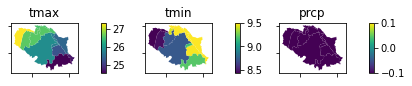

In [6]:
clim_file = Path('../prms/pipestem/daymet.nc')
#plot climate and return clim_file as xarray object
clim = helper.plot_climate2(clim_file, gdf_ps, msurf)



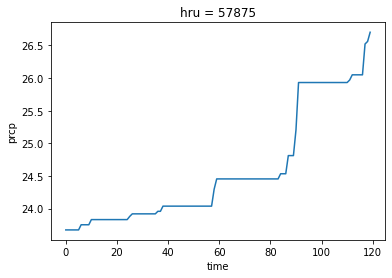

In [7]:
# plot cumulative sum to find precipitation event
cum_sum = clim.cumsum(dim='time')
cum_sum.prcp.isel(hru=1)[365:485].plot()

---

## Get some model time information

---

In [8]:
# Get time information from the model.
print(msurf.get_value('nowtime'))
# print(msoil.var['nowtime'].data)
print(f'Start time: {msurf.start_time}')
print(f'End time: {msurf.end_time}')
print(f'Current time : {msurf.time}')


[1980    1    1    0    0    0]
Start time: 0.0
End time: 731.0
Current time : 0.0


---
## Functions to couple Surface, Soil, Groundwater, and Streamflow BMIs
___

In [9]:
soil_input_cond_vars = ['soil_rechr_chg', 'soil_moist_chg']

surf2soil_vars = ['hru_ppt', 'hru_area_perv', 'hru_frac_perv', 'dprst_evap_hru', 
                   'dprst_seep_hru', 'infil', 'sroff','potet', 'hru_intcpevap', 
                   'snow_evap', 'snowcov_area', 'soil_rechr', 'soil_rechr_max', 
                   'soil_moist', 'soil_moist_max', 'hru_impervevap' , 
                   'srunoff_updated_soil','transp_on']

soil2surf_vars = ['infil', 'sroff', 'soil_rechr', 'soil_moist']

surf2gw_vars = ['pkwater_equiv', 'dprst_seep_hru', 'dprst_stor_hru', 'hru_intcpstor',
               'hru_impervstor', 'sroff']

soil2gw_vars = ['soil_moist_tot', 'soil_to_gw', 'ssr_to_gw', 'ssres_flow']

surf2sf_vars = ['potet', 'swrad', 'sroff']

soil2sf_vars = ['ssres_flow']

gw2sf_vars = ['gwres_flow']

def soilinput(msurf, msoil, exch_vars, cond_vars, dprst_flag, imperv_flag):
    for var in exch_vars:
        msoil.set_value(var, msurf.get_value(var))
    if dprst_flag in [1, 3] or imperv_flag in [1, 3]:
        for var in cond_vars:
            msoil.set_value(var, msurf.get_value(var))

def soil2surface(msoil, msurf, exch_vars):
    for var in exch_vars:
        msurf.set_value(var, msoil.get_value(var))
        
def gwinput(msurf, msoil, mgw, surf_vars, soil_vars):
    for var in surf_vars:
        mgw.set_value(var, msurf.get_value(var))
    for var in soil_vars:
        mgw.set_value(var, msoil.get_value(var))
        
def sfinput(msurf, msoil, mgw, msf, surf_vars, soil_vars, gw_vars):
    for var in surf_vars:
        msf.set_value(var, msurf.get_value(var))
    for var in soil_vars:
        msf.set_value(var, msoil.get_value(var))
    for var in gw_vars:
        msf.set_value(var, mgw.get_value(var))

        
dprst_flag = msoil.get_value('dyn_dprst_flag')
imperv_flag = msoil.get_value('dyn_imperv_flag')

def update_coupled(msurf, msoil, mgw, msf, dprst_flag, imperv_flag):
    msurf.update()
    soilinput(msurf, msoil, surf2soil_vars, soil_input_cond_vars, dprst_flag, imperv_flag)
    msoil.update()
    soil2surface(msoil, msurf, soil2surf_vars)
    gwinput(msurf, msoil, mgw, surf2gw_vars, soil2gw_vars)
    mgw.update()
    sfinput(msurf, msoil, mgw, msf, surf2sf_vars, soil2sf_vars, gw2sf_vars)
    msf.update()

---
Run for 1-year plus 90 days just prior to preciptation event in cumulative plot above

---

In [10]:
for time in range(455):
    update_coupled(msurf, msoil, mgw, msf, dprst_flag, imperv_flag)

---
Run for 7-days and plot results

---

Model time: 456.0, Date: 1981-03-31 00:00:00
Model time: 457.0, Date: 1981-04-01 00:00:00
Model time: 458.0, Date: 1981-04-02 00:00:00
Model time: 459.0, Date: 1981-04-03 00:00:00
Model time: 460.0, Date: 1981-04-04 00:00:00
Model time: 461.0, Date: 1981-04-05 00:00:00
Model time: 462.0, Date: 1981-04-06 00:00:00


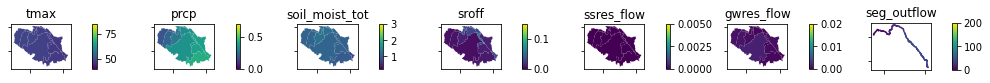

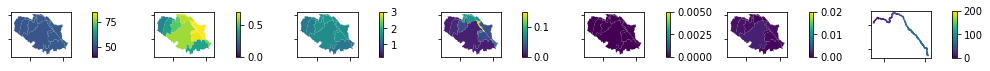

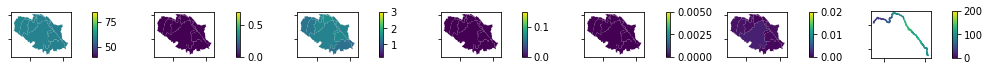

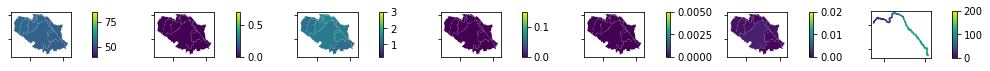

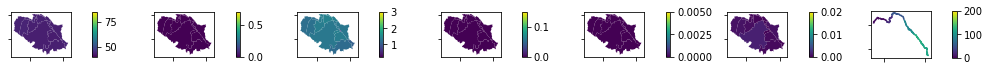

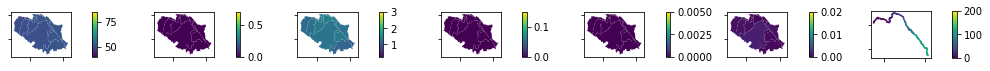

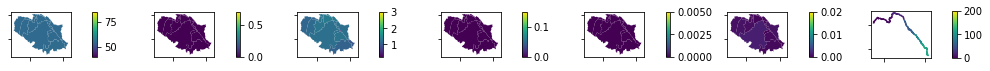

In [11]:

for i in range(7):
    update_coupled(msurf, msoil, mgw, msf, dprst_flag, imperv_flag)
    ptime = msurf.var['nowtime'].data
    timesel = dt.datetime(ptime[0], ptime[1], ptime[2])
    print(f'Model time: {msurf.time}, Date: {timesel}')
    helper.example_plot_strm(clim, gdf_ps, gdf_streams, msurf, msoil, mgw, msf, i, timesel)
#     helper.example_plot(clim, gdf_ps, msurf, msoil, i, timesel)

In [12]:
for i in range(19):
    update_coupled(msurf, msoil, mgw, msf, dprst_flag, imperv_flag)
    ptime = msurf.var['nowtime'].data
    timesel = dt.datetime(ptime[0], ptime[1], ptime[2])
    print(f'Model time: {msurf.time}, Date: {timesel}')

Model time: 463.0, Date: 1981-04-07 00:00:00
Model time: 464.0, Date: 1981-04-08 00:00:00
Model time: 465.0, Date: 1981-04-09 00:00:00
Model time: 466.0, Date: 1981-04-10 00:00:00
Model time: 467.0, Date: 1981-04-11 00:00:00
Model time: 468.0, Date: 1981-04-12 00:00:00
Model time: 469.0, Date: 1981-04-13 00:00:00
Model time: 470.0, Date: 1981-04-14 00:00:00
Model time: 471.0, Date: 1981-04-15 00:00:00
Model time: 472.0, Date: 1981-04-16 00:00:00
Model time: 473.0, Date: 1981-04-17 00:00:00
Model time: 474.0, Date: 1981-04-18 00:00:00
Model time: 475.0, Date: 1981-04-19 00:00:00
Model time: 476.0, Date: 1981-04-20 00:00:00
Model time: 477.0, Date: 1981-04-21 00:00:00
Model time: 478.0, Date: 1981-04-22 00:00:00
Model time: 479.0, Date: 1981-04-23 00:00:00
Model time: 480.0, Date: 1981-04-24 00:00:00
Model time: 481.0, Date: 1981-04-25 00:00:00


### Drive climate forcing with web-based data services - here Gridmet
* Pull Gridmet data from web-service for specified period and map to HRUs

In [13]:
# initialize Gridmet data service
gmdata = Gridmet("1981-04-26", end_date="1981-05-04", hrumap=True, hru_id=msurf.get_value('nhm_id'), wght_file=weight_file)

Model time: 482.0, Date: 1981-04-26 00:00:00
Model time: 483.0, Date: 1981-04-27 00:00:00
Model time: 484.0, Date: 1981-04-28 00:00:00
Model time: 485.0, Date: 1981-04-29 00:00:00
Model time: 486.0, Date: 1981-04-30 00:00:00
Model time: 487.0, Date: 1981-05-01 00:00:00
Model time: 488.0, Date: 1981-05-02 00:00:00


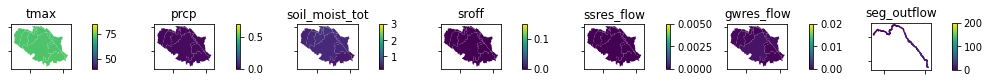

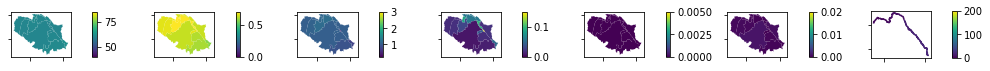

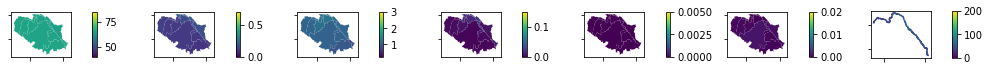

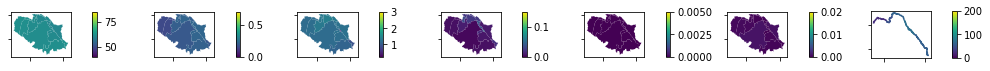

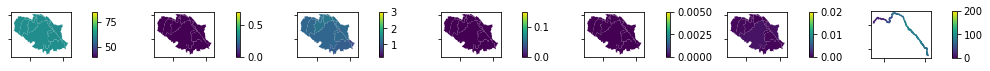

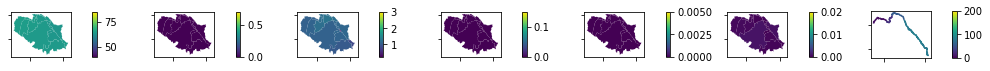

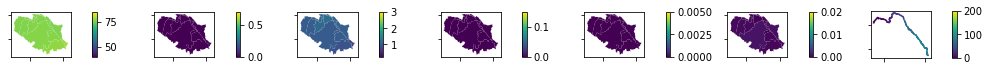

In [14]:

for i in np.arange(7):

    msurf.set_value('hru_ppt', (gmdata.precip.data[i,:]*.0393701).astype(np.float32))
    msurf.set_value('tmax', ((gmdata.tmax.data[i,:]*(9./5.))+32.0).astype(np.float32))
    msurf.set_value('tmin', ((gmdata.tmin.data[i,:]*(9./5.))+32.0).astype(np.float32))
#     print(gmdata.precip[i,:]*.0393701)
#     print((gmdata.tmax[i,:]*(9/5))+32.0)
#     print((gmdata.tmin[i,:]*(9/5))+32.0)    
    update_coupled(msurf, msoil, mgw, msf, dprst_flag, imperv_flag)
    ptime = msurf.var['nowtime'].data
    timesel = dt.datetime(ptime[0], ptime[1], ptime[2])
    print(f'Model time: {msurf.time}, Date: {timesel}')
#     print(gmdata.precip.data[i,:]*.0393701)
    helper.example_plot_strm(clim, gdf_ps, gdf_streams, msurf, msoil, mgw, msf, i, timesel)

---
In the next cell the precipitation, normally read from the netCDF file is overridden with user defined values.  Here we kick one HRU with a large amount of precipitation, 3", and view the response

---

Model time: 489.0, Date: 1981-05-03 00:00:00
Model time: 490.0, Date: 1981-05-04 00:00:00
Model time: 491.0, Date: 1981-05-05 00:00:00
Model time: 492.0, Date: 1981-05-06 00:00:00
Model time: 493.0, Date: 1981-05-07 00:00:00
Model time: 494.0, Date: 1981-05-08 00:00:00
Model time: 495.0, Date: 1981-05-09 00:00:00
Model time: 496.0, Date: 1981-05-10 00:00:00
Model time: 497.0, Date: 1981-05-11 00:00:00
Model time: 498.0, Date: 1981-05-12 00:00:00
Model time: 499.0, Date: 1981-05-13 00:00:00
Model time: 500.0, Date: 1981-05-14 00:00:00
Model time: 501.0, Date: 1981-05-15 00:00:00
Model time: 502.0, Date: 1981-05-16 00:00:00


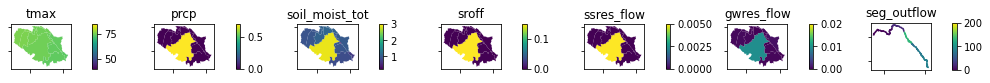

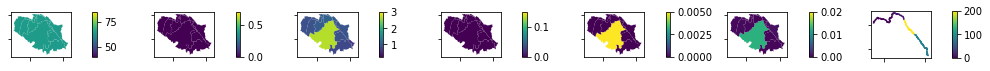

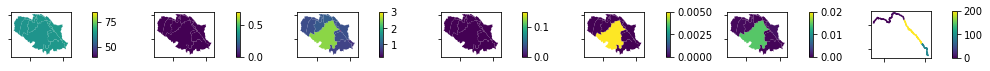

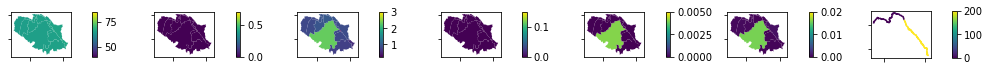

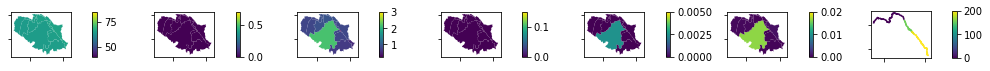

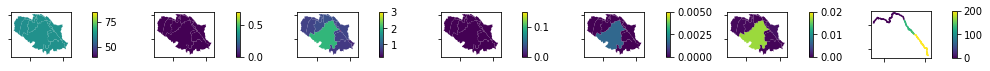

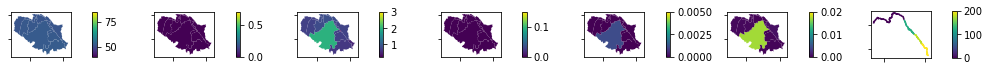

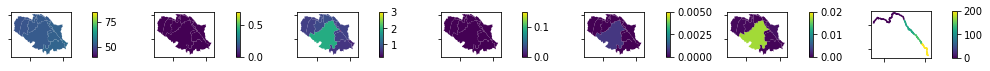

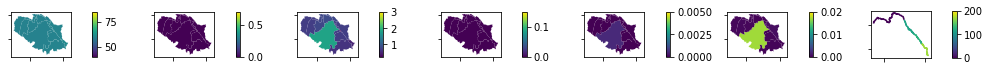

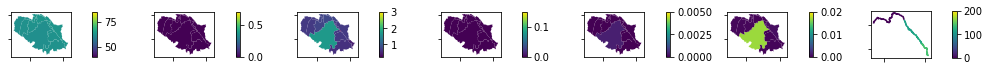

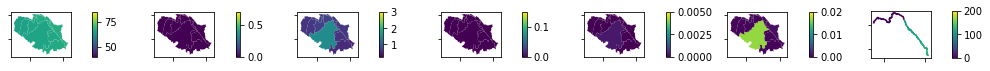

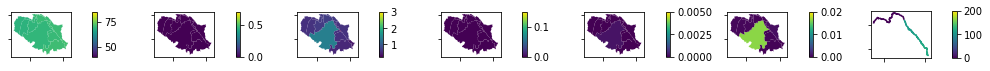

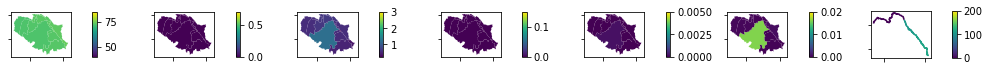

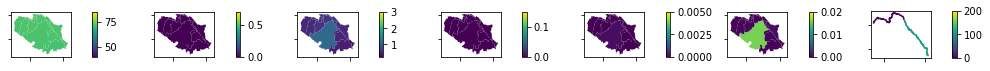

In [15]:

for i in range(14):
    if i == 0:
        grid_id = msurf.var_grid('hru_ppt')
        var_type = msurf.var_type('hru_ppt')
        grid_size = msurf.grid_node_count(grid_id)
        ppt_override = np.zeros(shape = (grid_size), dtype=var_type)
        ppt_override[0] = 3.0
        msurf.set_value('hru_ppt', ppt_override)
        
    update_coupled(msurf, msoil, mgw, msf, dprst_flag, imperv_flag)
    ptime = msurf.var['nowtime'].data
    timesel = dt.datetime(ptime[0], ptime[1], ptime[2])
    print(f'Model time: {msurf.time}, Date: {timesel}')
    helper.example_plot_strm(clim, gdf_ps, gdf_streams, msurf, msoil, mgw, msf, i, timesel)

View response at individual HRUs by reading the netCDF output files.

488.0 502.0


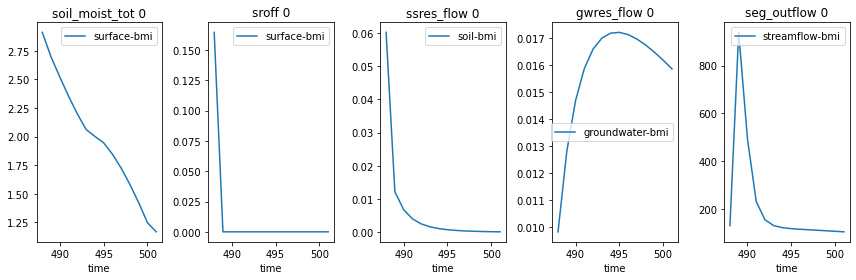

In [16]:
t_hru = 0
t_seg = 0
start_date = msoil.time-14
end_date = msoil.time
print(start_date, end_date)
import xarray as xr
surface_file = Path('../prms/pipestem/output/summary_surf_daily.nc')
soil_file = Path('../prms/pipestem/output/summary_soil_daily.nc')
gw_file = Path('../prms/pipestem/output/summary_gw_daily.nc')
strm_file = Path('../prms/pipestem/output/summary_streamflow_daily.nc')
dsurf = xr.open_dataset(surface_file, decode_times=False)
dsoil = xr.open_dataset(soil_file,  decode_times=False)
dgw = xr.open_dataset(gw_file,  decode_times=False)
dsf = xr.open_dataset(strm_file,  decode_times=False)

fig, ax = plt.subplots(ncols=5, figsize=(12,4))
helper.bmi_prms6_value_plot(dsoil, t_hru, 'soil_moist_tot', 'surface-bmi', start_date, end_date, ax[0])
helper.bmi_prms6_value_plot(dsurf, t_hru, 'sroff', 'surface-bmi', start_date, end_date, ax[1])
helper.bmi_prms6_value_plot(dsoil, t_hru, 'ssres_flow', 'soil-bmi', start_date, end_date, ax[2])
helper.bmi_prms6_value_plot(dgw, t_hru, 'gwres_flow', 'groundwater-bmi', start_date, end_date, ax[3])
helper.bmi_prms6_value_plot(dsf, t_seg, 'seg_outflow', 'streamflow-bmi', start_date, end_date, ax[4])
plt.tight_layout()
plt.show()


Finalize the BMIs and shut down

In [17]:
msurf.finalize()
msoil.finalize()
mgw.finalize()
msf.finalize()